# Get miRNA host genes to include in regulatory analysis

In [1]:
library(stringr)
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(ggplot2))
library(reshape2)

Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"

Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths




# Make bed file of mm10 genes

In [2]:
setwd("/share/crsp/lab/seyedam/share/enc4_mouse/snrna/")

In [3]:
## here's the GTF we're querying for miRNAs:
gtf <- rtracklayer::import('ref/gencode.vM21.primary_assembly.annotation_UCSC_names.gtf')
gtf_df=as.data.frame(gtf)
gtf_df_genes = gtf_df[gtf_df$type  == "gene",]

bed = gtf_df_genes[,c("seqnames","start","end",
                "gene_id")]
bed = unique(cbind(bed,rep(0,nrow(bed)),gtf_df_genes[,c("strand")]))

write.table(bed,file="ref/mm10_V21_ENCODE_scRNA_genes.bed",quote=F,row.names=F,col.names=F,sep="\t")


In [4]:
head(bed)
dim(bed)

,seqnames,start,end,gene_id,"rep(0, nrow(bed))","gtf_df_genes[, c(""strand"")]"
,<fct>,<int>,<int>,<chr>,<dbl>,<fct>
1,chr1,3073253,3074322,ENSMUSG00000102693.1,0,+
4,chr1,3102016,3102125,ENSMUSG00000064842.1,0,+
7,chr1,3205901,3671498,ENSMUSG00000051951.5,0,-
25,chr1,3252757,3253236,ENSMUSG00000102851.1,0,+
28,chr1,3365731,3368549,ENSMUSG00000103377.1,0,-
31,chr1,3375556,3377788,ENSMUSG00000104017.1,0,-


[1] 55536     6

# Get miRNA subset of mm10 bed file

In [5]:
gtf_df_mirnas = gtf_df[gtf_df$type  == "gene" & gtf_df$gene_type == "miRNA",]

bed = gtf_df_mirnas[,c("seqnames","start","end",
                "gene_id")]
bed = unique(cbind(bed,rep(0,nrow(bed)),gtf_df_mirnas[,c("strand")]))

write.table(bed,file="ref/mm10_V21_ENCODE_scRNA_mirnas.bed",quote=F,row.names=F,col.names=F,sep="\t")

In [6]:
head(bed)
dim(bed)

,seqnames,start,end,gene_id,"rep(0, nrow(bed))","gtf_df_mirnas[, c(""strand"")]"
,<fct>,<int>,<int>,<chr>,<dbl>,<fct>
889,chr1,5644645,5644745,ENSMUSG00000093015.1,0,-
1989,chr1,8588615,8588724,ENSMUSG00000093970.1,0,-
2001,chr1,8816138,8816247,ENSMUSG00000076135.1,0,+
4036,chr1,12425986,12426106,ENSMUSG00000098555.1,0,+
4678,chr1,13262198,13262279,ENSMUSG00000099183.1,0,+
5030,chr1,14182578,14182677,ENSMUSG00000095853.1,0,+


[1] 2207    6

# Intersect miRNA bed file with gene bed file 
### Bedtools intersect
- -s: keep strand info
- -F 1: UTR must overlap **all base pairs** in binding site
- -wo: of the UTRs overlapping the binding site, write the original A and B entries plus the number of base pairs of overlap between them



In [7]:
system("bedtools intersect -a ref/mm10_V21_ENCODE_scRNA_genes.bed -b ref/mm10_V21_ENCODE_scRNA_mirnas.bed -wo -s -F 1 > ref/mm10_V21_ENCODE_scRNA_mirna_host_genes.bed")


In [8]:
result = read.delim("ref/mm10_V21_ENCODE_scRNA_mirna_host_genes.bed",header=F)


In [9]:
head(result)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13
,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>
1,chr1,5644645,5644745,ENSMUSG00000093015.1,0,-,chr1,5644645,5644745,ENSMUSG00000093015.1,0,-,100
2,chr1,8361475,9299878,ENSMUSG00000025909.16,0,-,chr1,8588615,8588724,ENSMUSG00000093970.1,0,-,109
3,chr1,8588615,8588724,ENSMUSG00000093970.1,0,-,chr1,8588615,8588724,ENSMUSG00000093970.1,0,-,109
4,chr1,8816138,8816247,ENSMUSG00000076135.1,0,+,chr1,8816138,8816247,ENSMUSG00000076135.1,0,+,109
5,chr1,12425986,12426106,ENSMUSG00000098555.1,0,+,chr1,12425986,12426106,ENSMUSG00000098555.1,0,+,120
6,chr1,13262198,13262279,ENSMUSG00000099183.1,0,+,chr1,13262198,13262279,ENSMUSG00000099183.1,0,+,81


## Sanity check -- there should be 2,207 miRNAs that overlap with themselves 

In [10]:
mirs =  result[result$V4 == result$V10,]
dim(mirs)

[1] 2207   13

# Get genes that entirely overlap miRNAs

In [11]:
hgs = result[result$V4 != result$V10,]
gene_to_mir = unique(hgs[,c("V4","V10")])
colnames(gene_to_mir) = c("gene_id","mirna")

In [12]:
head(gene_to_mir) # this is the beginning of the df I want

,gene_id,mirna
,<chr>,<chr>
2,ENSMUSG00000025909.16,ENSMUSG00000093970.1
8,ENSMUSG00000099906.2,ENSMUSG00000065559.1
9,ENSMUSG00000099906.2,ENSMUSG00000065480.1
13,ENSMUSG00000097970.1,ENSMUSG00000065567.1
20,ENSMUSG00000026131.18,ENSMUSG00000105982.1
22,ENSMUSG00000102336.1,ENSMUSG00000092852.1


In [13]:
table(duplicated(gene_to_mir$mirna)) # 55 miRNAs have more than 1 host gene
table(duplicated(gene_to_mir$gene)) # 255 genes host more than 1 miRNA


FALSE  TRUE 
 1180    55 


FALSE  TRUE 
  980   255 

## 1180 miRNAs have 980 host genes. 1027 miRNAs have no host gene.


In [14]:
dim(mirs)[1]-1180 # 2207 annotated miRNAs - 1180 miRNAs with a host gene

[1] 1027

# Continue making miR-to-host gene table
Need the human-readable names. 

In [15]:
gtf <- rtracklayer::import('ref/gencode.vM21.primary_assembly.annotation_UCSC_names.gtf')
gtf_df=as.data.frame(gtf)
gtf_df_genes = gtf_df[gtf_df$type  == "gene",]
gtf_df_genes_to_name = gtf_df_genes[,c("gene_id","gene_name")]
head(gtf_df_genes_to_name)


,gene_id,gene_name
,<chr>,<chr>
1,ENSMUSG00000102693.1,4933401J01Rik
4,ENSMUSG00000064842.1,Gm26206
7,ENSMUSG00000051951.5,Xkr4
25,ENSMUSG00000102851.1,Gm18956
28,ENSMUSG00000103377.1,Gm37180
31,ENSMUSG00000104017.1,Gm37363


### First get the host gene name, then the miRNA name

In [16]:
gene_to_mir_gene_names = left_join(gene_to_mir, gtf_df_genes_to_name)
gene_to_mir_gene_names = gene_to_mir_gene_names[,c("gene_id","gene_name","mirna")]
colnames(gene_to_mir_gene_names) = c("host_gene_id","host_gene_name","gene_id")

gene_to_mir_gene_names = left_join(gene_to_mir_gene_names, gtf_df_genes_to_name)
colnames(gene_to_mir_gene_names) = c("host_gene_id","host_gene_name","mirna_id","mirna_name")

gene_to_mir_gene_names$host_gene_stable_id = do.call("rbind", strsplit(as.character(gene_to_mir_gene_names$host_gene_id), "[.]"))[,1]
gene_to_mir_gene_names$id = paste0(gene_to_mir_gene_names$host_gene_name," (",gene_to_mir_gene_names$mirna_name, ")")


Joining, by = "gene_id"
Joining, by = "gene_id"


In [17]:
head(gene_to_mir_gene_names)

,host_gene_id,host_gene_name,mirna_id,mirna_name,host_gene_stable_id,id
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000025909.16,Sntg1,ENSMUSG00000093970.1,Gm23358,ENSMUSG00000025909,Sntg1 (Gm23358)
2,ENSMUSG00000099906.2,Gm28653,ENSMUSG00000065559.1,Mir206,ENSMUSG00000099906,Gm28653 (Mir206)
3,ENSMUSG00000099906.2,Gm28653,ENSMUSG00000065480.1,Mir133b,ENSMUSG00000099906,Gm28653 (Mir133b)
4,ENSMUSG00000097970.1,Gm27028,ENSMUSG00000065567.1,Mir30c-2,ENSMUSG00000097970,Gm27028 (Mir30c-2)
5,ENSMUSG00000026131.18,Dst,ENSMUSG00000105982.1,Mir6896,ENSMUSG00000026131,Dst (Mir6896)
6,ENSMUSG00000102336.1,Gm37233,ENSMUSG00000092852.1,Mir5103,ENSMUSG00000102336,Gm37233 (Mir5103)


# Get miRNA data

In [18]:
metadata = read.csv('ref/mouse_mirna_metadata.tsv', head=TRUE,sep="\t" , 
                    stringsAsFactors = FALSE)
samples=metadata$File.accession

thisMat=read.table(paste0("mirna_data/",samples[1],".tsv"),sep="",head=FALSE)
counts=thisMat[-c(1:4),c(1,2)]

for(i in 2:length(samples)){
  thisMat=read.table(paste0("mirna_data/",samples[i],".tsv"),sep="",head=FALSE)
  thisMat=thisMat[na.omit(match(counts$V1,thisMat$V1)),]
  counts=as.data.frame(cbind(counts,thisMat[,"V2"]))
}

# Set rownames as ENSEMBL IDs
rownames(counts) = counts$V1
counts$V1 = NULL
# Set rownames as data IDs
colnames(counts) = metadata$File.accession

# Save full counts matrix with ensembl IDs
counts_full_ensembl = counts

postnatal_c2c12 = metadata$File.accession[!grepl("ENCDO835CXP",metadata$Donor.s.)]
counts_matching_sc_data = counts[,colnames(counts) %in% postnatal_c2c12]

metadata_postnatal_c2c12 = metadata[metadata$File.accession %in% postnatal_c2c12,]
table(colnames(counts_matching_sc_data) == metadata_postnatal_c2c12$File.accession)

metadata_postnatal_c2c12$Donor_sample = paste0(metadata_postnatal_c2c12$Donor.s.,"_",metadata_postnatal_c2c12$Sample)

# Use nice function from google to convert to CPM (counts per million)
cpm <- apply(counts_matching_sc_data,2, function(x) (x/sum(x))*1000000)

cpm = as.matrix(cpm)
rownames(cpm) = rownames(counts_matching_sc_data)
colnames(cpm) = colnames(counts_matching_sc_data)

colnames(cpm) = metadata_postnatal_c2c12$Donor_sample
cpm = as.data.frame(cpm)
cpm$mirna_id = rownames(cpm)
             



TRUE 
 324 

# Get mRNA data

In [23]:
metadata_rna = read.delim("ref/bulk_rna_metadata_fixed.txt")
metadata_rna$Donor_sample = paste0(metadata_rna$Donor.s.,"_",metadata_rna$Sample)

samples=metadata_rna$File.accession

thisMat=read.table(paste0("bulk_rna_data/",samples[1],".tsv"),head=T)
counts=thisMat[,c(1,6)]

for(i in 2:length(samples)){
  thisMat=read.table(paste0("bulk_rna_data/",samples[i],".tsv"),head=T)
  counts=as.data.frame(cbind(counts,thisMat[,"TPM"]))
}

# Set rownames as ENSEMBL IDs
tpm=counts
gid = tpm$gene_id
tpm$gene_id  = NULL
colnames(tpm) = metadata_rna$Donor_sample
tpm$host_gene_id = gid


## 289 common samples between miRNA and mRNA

In [24]:
table(colnames(tpm) %in% colnames(cpm))


FALSE  TRUE 
   57   289 

# Make mRNA matrix with rownames as gene name (miRNA)
Large batch effect between mRNA assay types, considering them separately.

## Subset mRNA expression for just the total RNA-seq assay

In [25]:
metadata_rna_total = metadata_rna[metadata_rna$Assay == "total RNA-seq",]
tpm_total = tpm
tpm_total = tpm_total[,colnames(tpm_total) %in% c(metadata_rna_total$Donor_sample,"host_gene_id")]

mrna_compare_total = left_join(gene_to_mir_gene_names,tpm_total)
mrna_compare_total$host_gene_id  = NULL
mrna_compare_total$host_gene_name  = NULL
mrna_compare_total$mirna_id  = NULL
mrna_compare_total$mirna_name  = NULL
mrna_compare_total$host_gene_stable_id  = NULL
rn = mrna_compare_total$id
mrna_compare_total$id  = NULL
mrna_compare_total = as.matrix(mrna_compare_total)
rownames(mrna_compare_total) = rn

Joining, by = "host_gene_id"


## Subset mRNA expression for just the polyA plus RNA-seq assay

In [26]:
metadata_rna_polya = metadata_rna[metadata_rna$Assay == "polyA plus RNA-seq",]
tpm_polya = tpm
tpm_polya = tpm_polya[,colnames(tpm_polya) %in% c(metadata_rna_polya$Donor_sample,"host_gene_id")]

mrna_compare_polya = left_join(gene_to_mir_gene_names,tpm_polya)
mrna_compare_polya$host_gene_id  = NULL
mrna_compare_polya$host_gene_name  = NULL
mrna_compare_polya$mirna_id  = NULL
mrna_compare_polya$mirna_name  = NULL
mrna_compare_polya$host_gene_stable_id  = NULL
rn = mrna_compare_polya$id
mrna_compare_polya$id  = NULL
mrna_compare_polya = as.matrix(mrna_compare_polya)
rownames(mrna_compare_polya) = rn

Joining, by = "host_gene_id"


# Make miRNA matrix with rownames as gene name (miRNA)

In [27]:
mirna_compare = left_join(gene_to_mir_gene_names,cpm)
mirna_compare$mirna_id  = NULL
mirna_compare$host_gene_id  = NULL
mirna_compare$host_gene_name  = NULL
mirna_compare$mirna_name  = NULL
mirna_compare$host_gene_stable_id  = NULL
rn = mirna_compare$id
mirna_compare$id  = NULL
mirna_compare = as.matrix(mirna_compare)
rownames(mirna_compare) = rn


Joining, by = "mirna_id"


In [28]:
table(colnames(mrna_compare_total) %in% colnames(mirna_compare))

table(colnames(mrna_compare_polya) %in% colnames(mirna_compare))



FALSE  TRUE 
    8   151 


FALSE  TRUE 
   48   138 

# Match up miRNA and mRNA data

In [29]:
mrna_compare_total = mrna_compare_total[,colnames(mrna_compare_total) %in% colnames(mirna_compare)]
mirna_compare_total = mirna_compare[,colnames(mirna_compare) %in% colnames(mrna_compare_total)]

mirna_compare_total = mirna_compare_total[, colnames(mrna_compare_total)]

table(rownames(mirna_compare_total) == rownames(mrna_compare_total))
table(colnames(mirna_compare_total) == colnames(mrna_compare_total))




TRUE 
1235 


TRUE 
 151 

In [30]:
mrna_compare_polya = mrna_compare_polya[,colnames(mrna_compare_polya) %in% colnames(mirna_compare)]
mirna_compare_polya = mirna_compare[,colnames(mirna_compare) %in% colnames(mrna_compare_polya)]

mirna_compare_polya = mirna_compare_polya[, colnames(mrna_compare_polya)]

table(rownames(mirna_compare_polya) == rownames(mrna_compare_polya))
table(colnames(mirna_compare_polya) == colnames(mrna_compare_polya))




TRUE 
1235 


TRUE 
 138 

## Plot cumulative distribution of spearman correlation
Calculated separately for total RNA-seq and polyA-plus RNA-seq

Warning message in cor(t(as.matrix(mirna_compare_total)), t(as.matrix(mrna_compare_total)), :
"the standard deviation is zero"
Warning message in cor(t(as.matrix(mirna_compare_polya)), t(as.matrix(mrna_compare_polya)), :
"the standard deviation is zero"


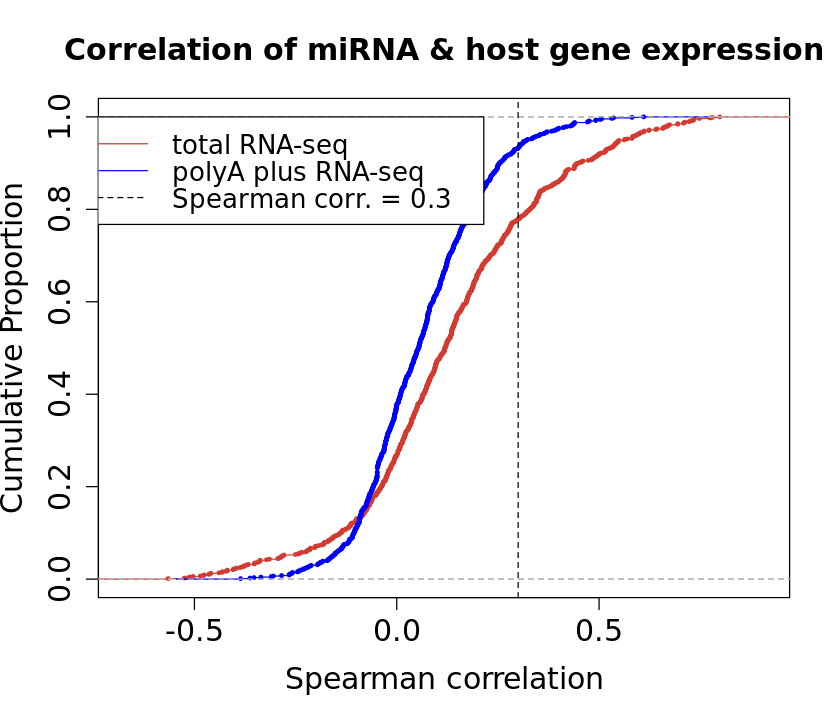

In [31]:
spearman_test_total = cor(t(as.matrix(mirna_compare_total)),t(as.matrix(mrna_compare_total)), method = "spearman")
spearman_test_polya = cor(t(as.matrix(mirna_compare_polya)),t(as.matrix(mrna_compare_polya)), method = "spearman")


df_total = as.data.frame(diag(spearman_test_total))
colnames(df_total) = "spearman_correlation"
df_total$link = rownames(df_total)
df_total = df_total[order(df_total$spearman_correlation),]

df_polya = as.data.frame(diag(spearman_test_polya))
colnames(df_polya) = "spearman_correlation"
df_polya$link = rownames(df_polya)
df_polya = df_polya[order(df_polya$spearman_correlation),]

options(repr.plot.width=7, repr.plot.height=6)

plot(ecdf(df_total[,"spearman_correlation"]),
     xlab="Spearman correlation",
     ylab="Cumulative Proportion",
     main="Correlation of miRNA & host gene expression", cex = 0.4,col="#d33b30",
    cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)

lines(ecdf(df_polya[,"spearman_correlation"]), cex = 0.4,col="blue",
    cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)

abline(v=0.3,lty=2)
legend(-0.8, 1, legend=c("total RNA-seq", "polyA plus RNA-seq","Spearman corr. = 0.3"),
       col=c("#d33b30", "blue","black"), lty=c(1,1,2), cex=1.3)


# Save reference file

In [32]:
df_polya$assay = "polyA plus RNA-seq"
df_total$assay = "total RNA-seq"
ref = rbind(df_polya,df_total)
ref$id = ref$link
ref = left_join(ref,gene_to_mir_gene_names)
ref$link = NULL

Joining, by = "id"


In [33]:
head(ref)
dim(ref)

,spearman_correlation,assay,id,host_gene_id,host_gene_name,mirna_id,mirna_name,host_gene_stable_id
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,-0.3858321,polyA plus RNA-seq,Sfmbt2 (Mir467e),ENSMUSG00000061186.15,Sfmbt2,ENSMUSG00000076948.2,Mir467e,ENSMUSG00000061186
2,-0.3627109,polyA plus RNA-seq,Gm20732 (Mir30d),ENSMUSG00000093387.1,Gm20732,ENSMUSG00000065437.1,Mir30d,ENSMUSG00000093387
3,-0.3528867,polyA plus RNA-seq,Arhgef17 (Mir3102),ENSMUSG00000032875.8,Arhgef17,ENSMUSG00000093296.1,Mir3102,ENSMUSG00000032875
4,-0.3357072,polyA plus RNA-seq,Fcgr3 (Mir6546),ENSMUSG00000059498.13,Fcgr3,ENSMUSG00000099119.1,Mir6546,ENSMUSG00000059498
5,-0.3100454,polyA plus RNA-seq,Srebf1 (Mir6922),ENSMUSG00000020538.15,Srebf1,ENSMUSG00000099259.1,Mir6922,ENSMUSG00000020538
6,-0.3048304,polyA plus RNA-seq,Hspg2 (Mir7018),ENSMUSG00000028763.17,Hspg2,ENSMUSG00000099134.1,Mir7018,ENSMUSG00000028763


[1] 2470    8

In [35]:
write.csv(ref,file="ref/mirna_hostGene_correlation.csv")